In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
# Load dataset with risk scores
df = pd.read_csv('../data/dataset_with_risk_scores.csv')
print(f"Loaded {len(df)} posts")
print(f"Conditions: {df['primary_label'].unique()}")

Loaded 78530 posts
Conditions: ['OCD' 'ADHD' 'aspergers' 'depression' 'ptsd']


In [ ]:
def get_top_words_per_class(df, text_col='post_text', label_col='primary_label', top_n=20):
    """
    Find words that are most distinctive for each condition using TF-IDF.
    """
    # Combine all posts per condition
    condition_texts = df.groupby(label_col)[text_col].apply(lambda x: ' '.join(x.dropna())).to_dict()
    
    conditions = list(condition_texts.keys())
    texts = [condition_texts[c] for c in conditions]
    
    # TF-IDF with conditions as "documents"
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        min_df=2,
        ngram_range=(1, 2)  # Include bigrams
    )
    
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top words per condition
    top_words = {}
    for idx, condition in enumerate(conditions):
        scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = scores.argsort()[-top_n:][::-1]
        top_words[condition] = [(feature_names[i], round(scores[i], 4)) for i in top_indices]
    
    return top_words

top_words = get_top_words_per_class(df, top_n=15)

print("=" * 70)
print("TOP DISTINCTIVE WORDS/PHRASES PER CONDITION (TF-IDF)")
print("=" * 70)

for condition, words in top_words.items():
    print(f"\n{condition.upper()}")
    print("-" * 40)
    for word, score in words[:10]:
        print(f"  • {word}: {score}")

TOP DISTINCTIVE WORDS/PHRASES PER CONDITION (TF-IDF)

📌 ADHD
----------------------------------------
  • just: 0.3812
  • like: 0.3671
  • adhd: 0.2454
  • feel: 0.2274
  • ve: 0.2063
  • don: 0.1933
  • time: 0.18
  • know: 0.1709
  • really: 0.1616
  • things: 0.1343

📌 OCD
----------------------------------------
  • deleted: 0.6776
  • like: 0.2827
  • just: 0.2335
  • ocd: 0.2062
  • removed: 0.2044
  • feel: 0.1766
  • don: 0.1625
  • know: 0.1365
  • ve: 0.1208
  • thoughts: 0.116

📌 ASPERGERS
----------------------------------------
  • like: 0.4086
  • just: 0.3561
  • people: 0.3023
  • don: 0.2562
  • feel: 0.1951
  • know: 0.1884
  • ve: 0.1773
  • time: 0.1625
  • really: 0.1423
  • things: 0.1337

📌 DEPRESSION
----------------------------------------
  • just: 0.4407
  • like: 0.313
  • don: 0.3088
  • feel: 0.2816
  • want: 0.227
  • know: 0.1987
  • life: 0.1981
  • people: 0.1566
  • ve: 0.1469
  • removed: 0.1163

📌 PTSD
----------------------------------------
  • j

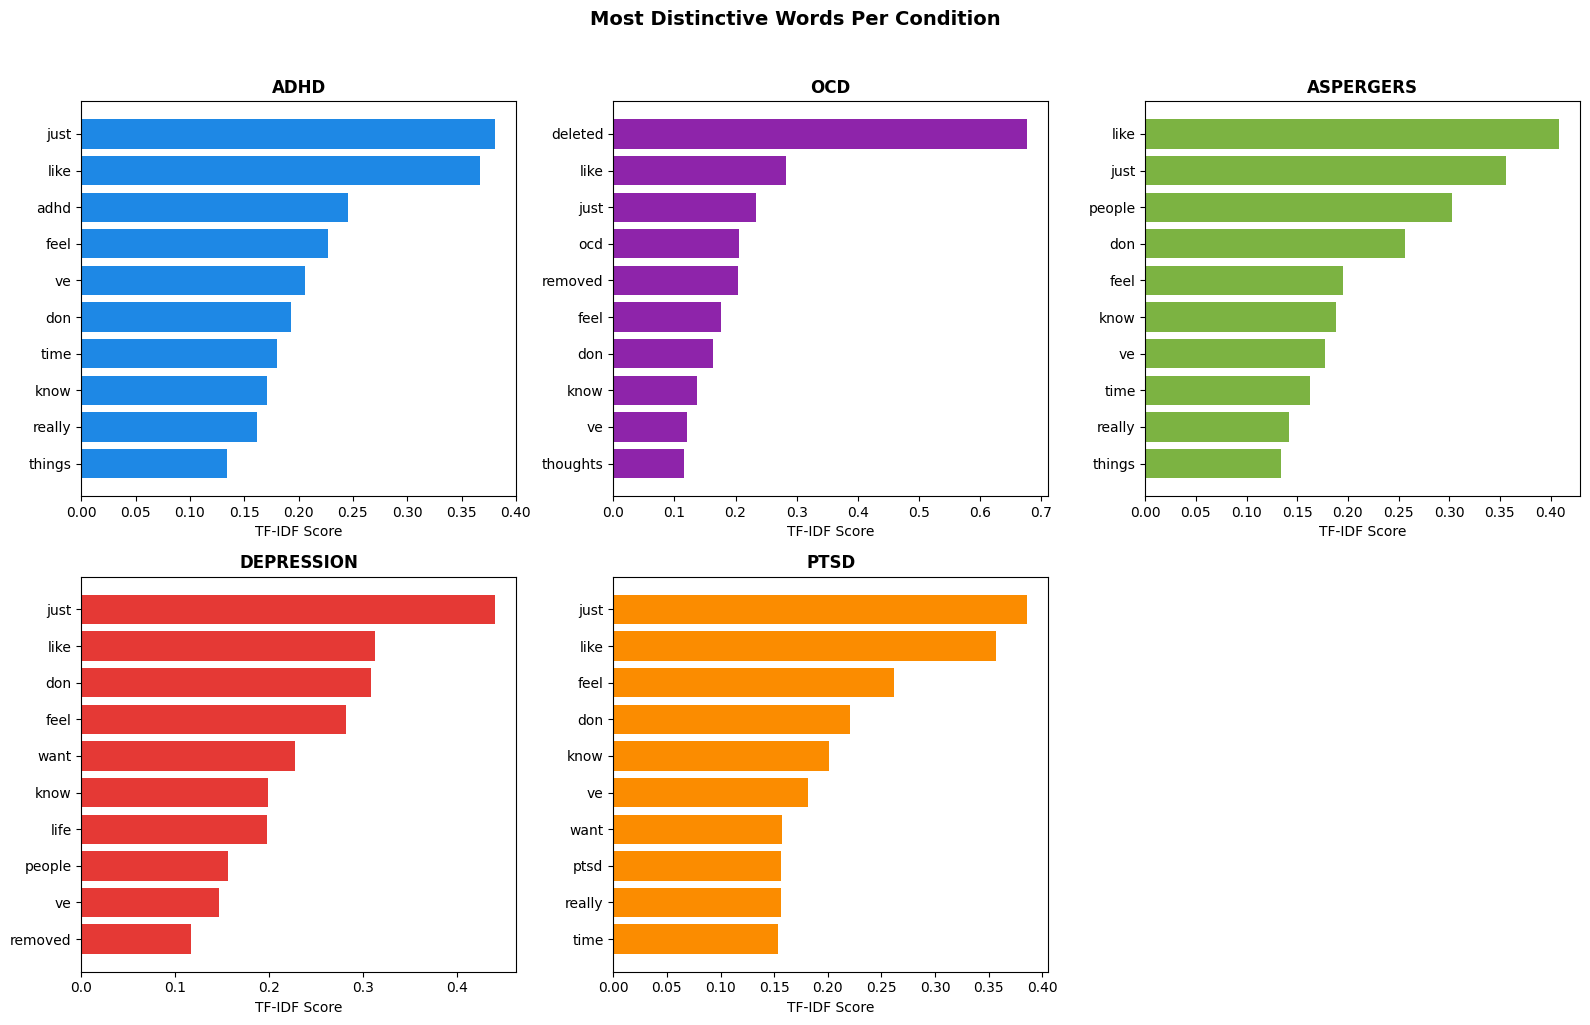

✓ Saved: results/distinctive_words_per_condition.png


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = {
    'depression': '#E53935',
    'ptsd': '#FB8C00', 
    'aspergers': '#7CB342',
    'ADHD': '#1E88E5',
    'OCD': '#8E24AA'
}

for idx, (condition, words) in enumerate(top_words.items()):
    if idx >= 5:
        break
    
    ax = axes[idx]
    words_only = [w[0] for w in words[:10]]
    scores = [w[1] for w in words[:10]]
    
    bars = ax.barh(range(len(words_only)), scores, color=colors.get(condition, 'steelblue'))
    ax.set_yticks(range(len(words_only)))
    ax.set_yticklabels(words_only, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('TF-IDF Score', fontsize=10)
    ax.set_title(f'{condition.upper()}', fontsize=12, fontweight='bold')

# Hide empty subplot
axes[5].axis('off')

plt.suptitle('Most Distinctive Words Per Condition', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/distinctive_words_per_condition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/distinctive_words_per_condition.png")

In [5]:
def highlight_risk_words(text, return_html=False):
    """
    Identify and highlight risk-related words in text.
    Returns list of detected words with categories.
    """
    if not text or not isinstance(text, str):
        return {'highlighted_words': [], 'categories': {}}
    
    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)
    
    # Define word categories
    categories = {
        'negative_emotion': {'sad', 'depressed', 'anxious', 'worried', 'afraid', 'scared', 
                            'hopeless', 'worthless', 'miserable', 'lonely', 'empty', 'exhausted',
                            'overwhelmed', 'stressed', 'panic', 'hate', 'pain', 'hurt', 'helpless'},
        'absolutist': {'always', 'never', 'nothing', 'everything', 'completely', 'totally',
                      'impossible', 'forever', 'constantly'},
        'crisis': {'suicide', 'suicidal', 'die', 'death', 'end', 'give up', 'cant go on'},
        'cognitive': {'should', 'must', 'cant', "can't", 'ruined', 'failed', 'failure', 'worst'}
    }
    
    detected = {cat: [] for cat in categories}
    
    for word in words:
        for category, word_set in categories.items():
            if word in word_set:
                detected[category].append(word)
    
    # Flatten for summary
    all_detected = []
    for cat, words_list in detected.items():
        for w in words_list:
            all_detected.append({'word': w, 'category': cat})
    
    return {
        'highlighted_words': all_detected,
        'categories': {k: list(set(v)) for k, v in detected.items() if v}
    }

# Test
test_text = "I always feel so hopeless and worthless. Nothing ever works out and I can't do anything right. I'm completely exhausted."
result = highlight_risk_words(test_text)

print("=" * 70)
print("WORD HIGHLIGHTING EXAMPLE")
print("=" * 70)
print(f"\nText: \"{test_text}\"\n")
print("Detected Risk Words:")
for cat, words in result['categories'].items():
    print(f"  {cat}: {words}")

WORD HIGHLIGHTING EXAMPLE

Text: "I always feel so hopeless and worthless. Nothing ever works out and I can't do anything right. I'm completely exhausted."

Detected Risk Words:
  negative_emotion: ['hopeless', 'worthless', 'exhausted']
  absolutist: ['nothing', 'completely', 'always']


In [ ]:
# Find unique phrases that appear mostly in one condition
def find_condition_specific_phrases(df, min_ratio=3.0):
    """
    Find phrases that appear at least min_ratio times more often 
    in one condition than others.
    """
    conditions = df['primary_label'].unique()
    
    # Get word frequencies per condition
    condition_word_freq = {}
    for condition in conditions:
        texts = df[df['primary_label'] == condition]['post_text'].dropna()
        all_words = ' '.join(texts).lower()
        words = re.findall(r'\b[a-z]{3,}\b', all_words)  # Words with 3+ chars
        condition_word_freq[condition] = Counter(words)
    
    # Normalize by condition size
    condition_sizes = df['primary_label'].value_counts().to_dict()
    
    # Find distinctive words
    distinctive = {c: [] for c in conditions}
    
    all_words = set()
    for freq in condition_word_freq.values():
        all_words.update(freq.keys())
    
    for word in all_words:
        freqs = {}
        for condition in conditions:
            count = condition_word_freq[condition].get(word, 0)
            normalized = count / condition_sizes[condition] * 1000  # per 1000 posts
            freqs[condition] = normalized
        
        max_condition = max(freqs, key=freqs.get)
        max_freq = freqs[max_condition]
        
        other_freqs = [f for c, f in freqs.items() if c != max_condition]
        avg_other = np.mean(other_freqs) if other_freqs else 0
        
        if avg_other > 0 and max_freq / avg_other >= min_ratio and max_freq > 5:
            distinctive[max_condition].append((word, round(max_freq / avg_other, 1), round(max_freq, 1)))
    
    # Sort by ratio
    for condition in distinctive:
        distinctive[condition] = sorted(distinctive[condition], key=lambda x: x[1], reverse=True)[:10]
    
    return distinctive

distinctive_phrases = find_condition_specific_phrases(df, min_ratio=2.0)

print("=" * 70)
print("CONDITION-SPECIFIC LANGUAGE PATTERNS")
print("=" * 70)
print("(Words that appear disproportionately in each condition)\n")

for condition, phrases in distinctive_phrases.items():
    print(f"{condition.upper()}")
    for word, ratio, freq in phrases[:7]:
        print(f"   • '{word}' - {ratio}x more common (freq: {freq}/1000 posts)")
    print()

CONDITION-SPECIFIC LANGUAGE PATTERNS
(Words that appear disproportionately in each condition)

📌 OCD
   • 'pocd' - 270.6x more common (freq: 10.9/1000 posts)
   • 'deleted' - 227.6x more common (freq: 606.0/1000 posts)
   • 'hocd' - 55.5x more common (freq: 8.8/1000 posts)
   • 'erp' - 29.3x more common (freq: 9.6/1000 posts)
   • 'compulsions' - 13.0x more common (freq: 18.3/1000 posts)
   • 'reassurance' - 12.1x more common (freq: 8.4/1000 posts)
   • 'compulsion' - 9.0x more common (freq: 11.2/1000 posts)

📌 ADHD
   • 'amphetamine' - 1685.8x more common (freq: 6.6/1000 posts)
   • 'focalin' - 1612.5x more common (freq: 6.3/1000 posts)
   • 'dexedrine' - 879.5x more common (freq: 10.3/1000 posts)
   • 'elvanse' - 733.0x more common (freq: 8.6/1000 posts)
   • 'ritalin' - 157.3x more common (freq: 41.9/1000 posts)
   • 'strattera' - 144.6x more common (freq: 21.2/1000 posts)
   • 'vyvanse' - 113.7x more common (freq: 79.7/1000 posts)

📌 ASPERGERS
   • 'aspies' - 142.4x more common (fr

In [7]:
# Save for Streamlit
explainability_module = '''
import re
from collections import Counter

def highlight_risk_words(text):
    """Identify and highlight risk-related words in text."""
    if not text or not isinstance(text, str):
        return {'highlighted_words': [], 'categories': {}}
    
    text_lower = text.lower()
    words = re.findall(r'\\b\\w+\\b', text_lower)
    
    categories = {
        'negative_emotion': {'sad', 'depressed', 'anxious', 'worried', 'afraid', 'scared', 
                            'hopeless', 'worthless', 'miserable', 'lonely', 'empty', 'exhausted',
                            'overwhelmed', 'stressed', 'panic', 'hate', 'pain', 'hurt', 'helpless'},
        'absolutist': {'always', 'never', 'nothing', 'everything', 'completely', 'totally',
                      'impossible', 'forever', 'constantly'},
        'crisis': {'suicide', 'suicidal', 'die', 'death', 'end', 'give up'},
        'cognitive': {'should', 'must', 'cant', "can't", 'ruined', 'failed', 'failure', 'worst'}
    }
    
    detected = {cat: [] for cat in categories}
    
    for word in words:
        for category, word_set in categories.items():
            if word in word_set:
                detected[category].append(word)
    
    all_detected = []
    for cat, words_list in detected.items():
        for w in words_list:
            all_detected.append({'word': w, 'category': cat})
    
    return {
        'highlighted_words': all_detected,
        'categories': {k: list(set(v)) for k, v in detected.items() if v}
    }

# Condition-specific keywords for prediction explanation
CONDITION_KEYWORDS = {
    'depression': ['hopeless', 'worthless', 'empty', 'sad', 'crying', 'alone', 'tired', 'exhausted', 'numb'],
    'ADHD': ['focus', 'distracted', 'hyperactive', 'impulsive', 'attention', 'concentrate', 'forgot', 'late'],
    'OCD': ['obsessive', 'compulsive', 'intrusive', 'ritual', 'contamination', 'checking', 'counting', 'symmetry'],
    'ptsd': ['trauma', 'flashback', 'nightmare', 'trigger', 'hypervigilant', 'startle', 'avoid', 'numb'],
    'aspergers': ['social', 'sensory', 'routine', 'literal', 'eye contact', 'special interest', 'masking']
}

def explain_prediction(text, predicted_class, confidence):
    """Generate explanation for why a prediction was made."""
    text_lower = text.lower()
    
    # Find matching keywords
    keywords_found = []
    for keyword in CONDITION_KEYWORDS.get(predicted_class, []):
        if keyword in text_lower:
            keywords_found.append(keyword)
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence,
        'keywords_found': keywords_found,
        'explanation': f"Detected {len(keywords_found)} keywords associated with {predicted_class}"
    }
'''

with open('../src/explainability.py', 'w') as f:
    f.write(explainability_module)

print("✓ Saved: src/explainability.py")
print("\n" + "=" * 70)
print("STEP 2 COMPLETE: Explainability")
print("=" * 70)

✓ Saved: src/explainability.py

STEP 2 COMPLETE: Explainability
